# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

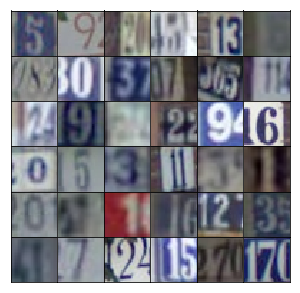

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    init_dim =[-1,4,4,512]
    init_len = 4*4*512
    filters = 512
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = training)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        # so now we're at 4x4x512
        for i in range(3):
            if i<2:
                filters = filters/2
            else:
                filters = output_dim
                
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')
                                           
            x = tf.layers.batch_normalization(x, training = training)
            if i < 2:
                x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        # Output layer, 32x32x3
        logits = x
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 32x32x3
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 20
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/20... Discriminator Loss: 1.4241... Generator Loss: 0.7257
Epoch 1/20... Discriminator Loss: 0.3499... Generator Loss: 2.9843
Epoch 1/20... Discriminator Loss: 0.1470... Generator Loss: 3.1992
Epoch 1/20... Discriminator Loss: 0.2077... Generator Loss: 2.2636
Epoch 1/20... Discriminator Loss: 0.2121... Generator Loss: 2.4548
Epoch 1/20... Discriminator Loss: 0.1302... Generator Loss: 2.7773
Epoch 1/20... Discriminator Loss: 0.1762... Generator Loss: 2.3918
Epoch 1/20... Discriminator Loss: 0.2235... Generator Loss: 2.3422
Epoch 1/20... Discriminator Loss: 0.3677... Generator Loss: 1.9891
Epoch 1/20... Discriminator Loss: 0.5685... Generator Loss: 1.9754


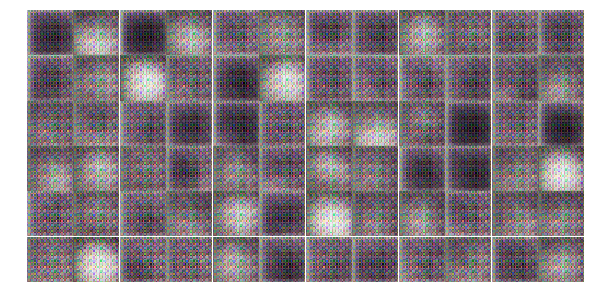

Epoch 1/20... Discriminator Loss: 0.3915... Generator Loss: 3.5066
Epoch 1/20... Discriminator Loss: 0.5835... Generator Loss: 4.8746
Epoch 1/20... Discriminator Loss: 0.4531... Generator Loss: 1.8638
Epoch 1/20... Discriminator Loss: 0.3299... Generator Loss: 2.3780
Epoch 1/20... Discriminator Loss: 0.7655... Generator Loss: 1.0476
Epoch 1/20... Discriminator Loss: 0.5960... Generator Loss: 1.2584
Epoch 1/20... Discriminator Loss: 0.2429... Generator Loss: 2.2821
Epoch 1/20... Discriminator Loss: 0.3087... Generator Loss: 2.4438
Epoch 1/20... Discriminator Loss: 0.8291... Generator Loss: 1.3674
Epoch 1/20... Discriminator Loss: 0.5169... Generator Loss: 3.0276


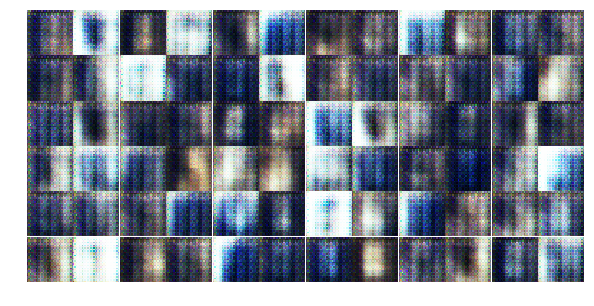

Epoch 1/20... Discriminator Loss: 0.4154... Generator Loss: 1.7876
Epoch 1/20... Discriminator Loss: 0.3797... Generator Loss: 1.6917
Epoch 1/20... Discriminator Loss: 0.5946... Generator Loss: 1.4379
Epoch 1/20... Discriminator Loss: 0.4946... Generator Loss: 1.3415
Epoch 1/20... Discriminator Loss: 0.3010... Generator Loss: 2.2383
Epoch 1/20... Discriminator Loss: 0.3485... Generator Loss: 2.0691
Epoch 1/20... Discriminator Loss: 1.0200... Generator Loss: 0.7322
Epoch 1/20... Discriminator Loss: 1.2366... Generator Loss: 3.3190
Epoch 1/20... Discriminator Loss: 0.5022... Generator Loss: 1.8541
Epoch 1/20... Discriminator Loss: 0.4683... Generator Loss: 1.7966


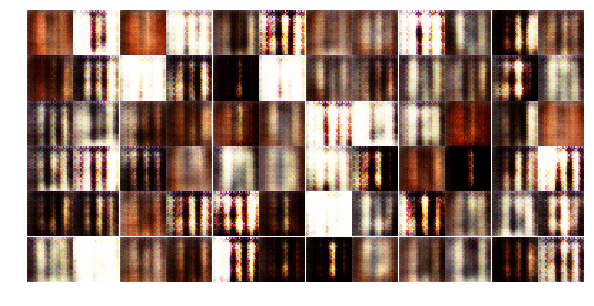

Epoch 1/20... Discriminator Loss: 0.7445... Generator Loss: 2.0549
Epoch 1/20... Discriminator Loss: 0.6937... Generator Loss: 1.7766
Epoch 1/20... Discriminator Loss: 0.4512... Generator Loss: 1.8298
Epoch 1/20... Discriminator Loss: 0.7996... Generator Loss: 0.9050
Epoch 1/20... Discriminator Loss: 0.4626... Generator Loss: 2.5319
Epoch 1/20... Discriminator Loss: 0.6185... Generator Loss: 1.2774
Epoch 1/20... Discriminator Loss: 0.3413... Generator Loss: 2.5632
Epoch 1/20... Discriminator Loss: 0.5087... Generator Loss: 1.8285
Epoch 1/20... Discriminator Loss: 1.1511... Generator Loss: 1.7266
Epoch 1/20... Discriminator Loss: 0.5570... Generator Loss: 2.1034


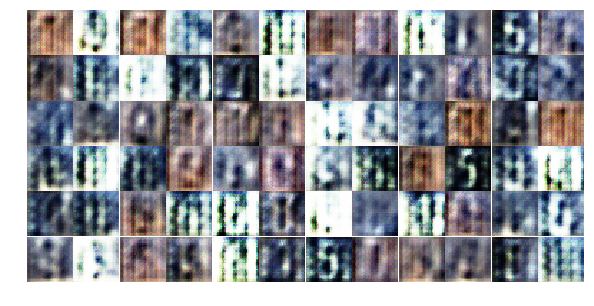

Epoch 1/20... Discriminator Loss: 0.3903... Generator Loss: 1.6468
Epoch 1/20... Discriminator Loss: 0.5634... Generator Loss: 1.2227
Epoch 1/20... Discriminator Loss: 1.3749... Generator Loss: 3.6338
Epoch 1/20... Discriminator Loss: 0.9270... Generator Loss: 0.9891
Epoch 1/20... Discriminator Loss: 0.6098... Generator Loss: 1.3892
Epoch 1/20... Discriminator Loss: 1.2996... Generator Loss: 0.4174
Epoch 1/20... Discriminator Loss: 0.5122... Generator Loss: 2.2961
Epoch 1/20... Discriminator Loss: 1.3454... Generator Loss: 0.4508
Epoch 1/20... Discriminator Loss: 0.4585... Generator Loss: 1.6918
Epoch 1/20... Discriminator Loss: 0.8415... Generator Loss: 0.9878


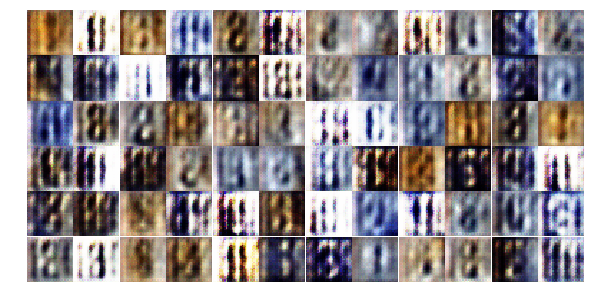

Epoch 1/20... Discriminator Loss: 0.4529... Generator Loss: 2.4926
Epoch 1/20... Discriminator Loss: 0.6398... Generator Loss: 2.7087
Epoch 1/20... Discriminator Loss: 1.1588... Generator Loss: 0.6207
Epoch 1/20... Discriminator Loss: 0.7575... Generator Loss: 2.0891
Epoch 1/20... Discriminator Loss: 0.6335... Generator Loss: 1.4938
Epoch 1/20... Discriminator Loss: 1.3989... Generator Loss: 0.3819
Epoch 1/20... Discriminator Loss: 0.6869... Generator Loss: 1.5161
Epoch 2/20... Discriminator Loss: 1.0299... Generator Loss: 1.7681
Epoch 2/20... Discriminator Loss: 0.4336... Generator Loss: 2.0172
Epoch 2/20... Discriminator Loss: 0.7986... Generator Loss: 1.3015


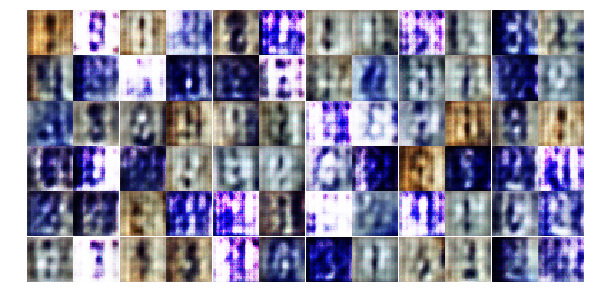

Epoch 2/20... Discriminator Loss: 1.2379... Generator Loss: 0.5371
Epoch 2/20... Discriminator Loss: 0.6594... Generator Loss: 1.9089
Epoch 2/20... Discriminator Loss: 0.8526... Generator Loss: 1.1156
Epoch 2/20... Discriminator Loss: 0.4181... Generator Loss: 2.1918
Epoch 2/20... Discriminator Loss: 0.6096... Generator Loss: 1.4335
Epoch 2/20... Discriminator Loss: 0.7916... Generator Loss: 1.0622
Epoch 2/20... Discriminator Loss: 0.5620... Generator Loss: 2.1310
Epoch 2/20... Discriminator Loss: 0.9758... Generator Loss: 1.5056
Epoch 2/20... Discriminator Loss: 0.4647... Generator Loss: 2.4660
Epoch 2/20... Discriminator Loss: 0.7602... Generator Loss: 1.1780


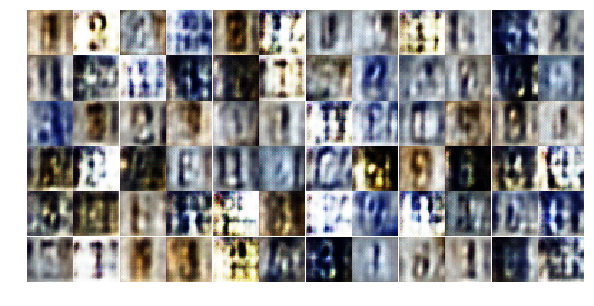

Epoch 2/20... Discriminator Loss: 0.6326... Generator Loss: 1.3825
Epoch 2/20... Discriminator Loss: 0.6903... Generator Loss: 2.9734
Epoch 2/20... Discriminator Loss: 1.1126... Generator Loss: 0.6519
Epoch 2/20... Discriminator Loss: 0.3328... Generator Loss: 2.3060
Epoch 2/20... Discriminator Loss: 0.9683... Generator Loss: 1.7076
Epoch 2/20... Discriminator Loss: 0.6987... Generator Loss: 1.8993
Epoch 2/20... Discriminator Loss: 0.8151... Generator Loss: 2.0282
Epoch 2/20... Discriminator Loss: 0.6430... Generator Loss: 1.3514
Epoch 2/20... Discriminator Loss: 0.8588... Generator Loss: 1.0629
Epoch 2/20... Discriminator Loss: 0.6851... Generator Loss: 1.3213


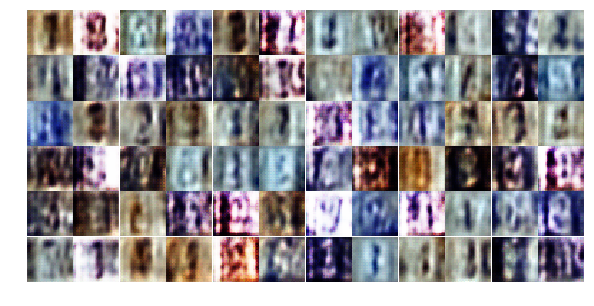

Epoch 2/20... Discriminator Loss: 1.5248... Generator Loss: 0.3269
Epoch 2/20... Discriminator Loss: 0.9209... Generator Loss: 1.9651
Epoch 2/20... Discriminator Loss: 0.8109... Generator Loss: 1.7592
Epoch 2/20... Discriminator Loss: 0.7291... Generator Loss: 1.0147
Epoch 2/20... Discriminator Loss: 1.0162... Generator Loss: 2.6710
Epoch 2/20... Discriminator Loss: 0.5491... Generator Loss: 2.2593
Epoch 2/20... Discriminator Loss: 0.8189... Generator Loss: 0.9558
Epoch 2/20... Discriminator Loss: 1.6611... Generator Loss: 0.2807
Epoch 2/20... Discriminator Loss: 1.1961... Generator Loss: 0.6524
Epoch 2/20... Discriminator Loss: 0.7876... Generator Loss: 0.9508


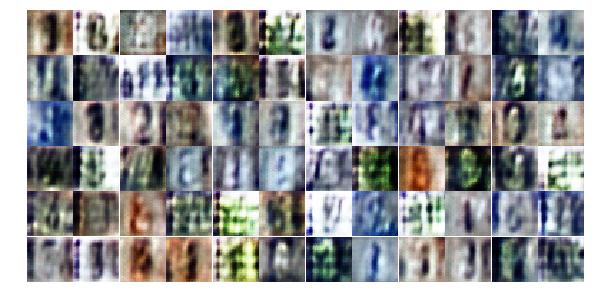

Epoch 2/20... Discriminator Loss: 1.1357... Generator Loss: 0.8303
Epoch 2/20... Discriminator Loss: 0.5080... Generator Loss: 1.7288
Epoch 2/20... Discriminator Loss: 0.6689... Generator Loss: 0.9661
Epoch 2/20... Discriminator Loss: 0.4772... Generator Loss: 1.6854
Epoch 2/20... Discriminator Loss: 0.4020... Generator Loss: 2.2568
Epoch 2/20... Discriminator Loss: 0.5610... Generator Loss: 2.5441
Epoch 2/20... Discriminator Loss: 0.9257... Generator Loss: 2.2507
Epoch 2/20... Discriminator Loss: 0.5959... Generator Loss: 2.0070
Epoch 2/20... Discriminator Loss: 1.0062... Generator Loss: 2.4601
Epoch 2/20... Discriminator Loss: 0.9576... Generator Loss: 0.7818


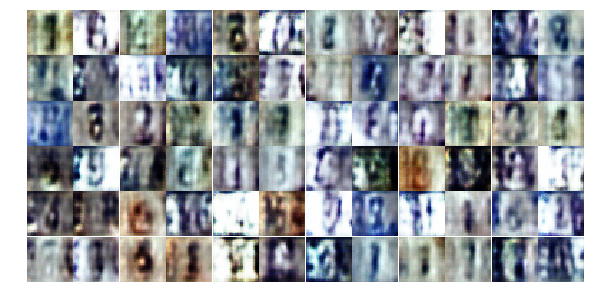

Epoch 2/20... Discriminator Loss: 0.4071... Generator Loss: 1.8940
Epoch 2/20... Discriminator Loss: 0.8340... Generator Loss: 2.0527
Epoch 2/20... Discriminator Loss: 0.7407... Generator Loss: 1.2524
Epoch 2/20... Discriminator Loss: 0.7403... Generator Loss: 1.3503
Epoch 2/20... Discriminator Loss: 0.8695... Generator Loss: 0.8658
Epoch 2/20... Discriminator Loss: 1.9488... Generator Loss: 0.2986
Epoch 2/20... Discriminator Loss: 0.6903... Generator Loss: 1.3226
Epoch 2/20... Discriminator Loss: 0.6203... Generator Loss: 1.5400
Epoch 2/20... Discriminator Loss: 0.5977... Generator Loss: 2.0435
Epoch 2/20... Discriminator Loss: 1.4105... Generator Loss: 2.5365


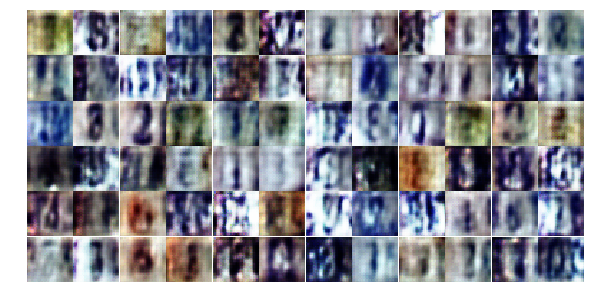

Epoch 2/20... Discriminator Loss: 0.7976... Generator Loss: 2.2968
Epoch 2/20... Discriminator Loss: 0.6337... Generator Loss: 1.3533
Epoch 2/20... Discriminator Loss: 1.2077... Generator Loss: 0.5740
Epoch 2/20... Discriminator Loss: 0.5448... Generator Loss: 1.8752
Epoch 3/20... Discriminator Loss: 0.6264... Generator Loss: 1.5162
Epoch 3/20... Discriminator Loss: 0.9593... Generator Loss: 1.4932
Epoch 3/20... Discriminator Loss: 0.6871... Generator Loss: 1.8556
Epoch 3/20... Discriminator Loss: 0.7210... Generator Loss: 1.2809
Epoch 3/20... Discriminator Loss: 0.8584... Generator Loss: 0.9065
Epoch 3/20... Discriminator Loss: 0.7362... Generator Loss: 1.3787


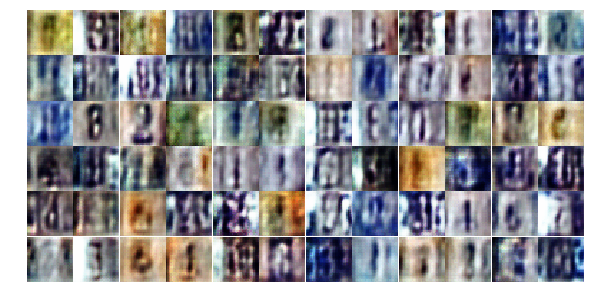

Epoch 3/20... Discriminator Loss: 0.5509... Generator Loss: 2.1597
Epoch 3/20... Discriminator Loss: 0.5205... Generator Loss: 1.5285
Epoch 3/20... Discriminator Loss: 0.9907... Generator Loss: 0.7797
Epoch 3/20... Discriminator Loss: 0.8587... Generator Loss: 0.7793
Epoch 3/20... Discriminator Loss: 1.3998... Generator Loss: 0.7126
Epoch 3/20... Discriminator Loss: 0.9495... Generator Loss: 0.7592
Epoch 3/20... Discriminator Loss: 1.2656... Generator Loss: 0.5208
Epoch 3/20... Discriminator Loss: 0.8695... Generator Loss: 0.7366
Epoch 3/20... Discriminator Loss: 0.8926... Generator Loss: 0.9713
Epoch 3/20... Discriminator Loss: 0.9489... Generator Loss: 0.7430


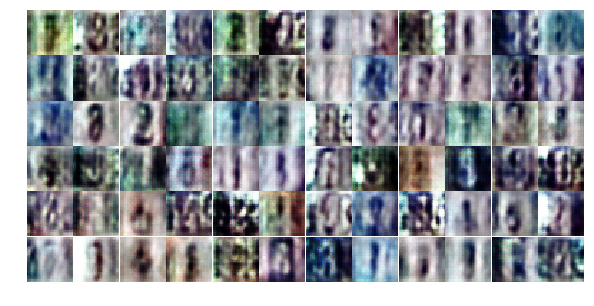

Epoch 3/20... Discriminator Loss: 0.8354... Generator Loss: 0.9460
Epoch 3/20... Discriminator Loss: 0.9279... Generator Loss: 1.0026
Epoch 3/20... Discriminator Loss: 0.6920... Generator Loss: 1.3263
Epoch 3/20... Discriminator Loss: 1.3709... Generator Loss: 0.4202
Epoch 3/20... Discriminator Loss: 0.9155... Generator Loss: 1.3694
Epoch 3/20... Discriminator Loss: 0.9609... Generator Loss: 1.1604
Epoch 3/20... Discriminator Loss: 0.4788... Generator Loss: 2.2740
Epoch 3/20... Discriminator Loss: 0.7829... Generator Loss: 1.0272
Epoch 3/20... Discriminator Loss: 0.6817... Generator Loss: 1.0460
Epoch 3/20... Discriminator Loss: 0.7968... Generator Loss: 1.0403


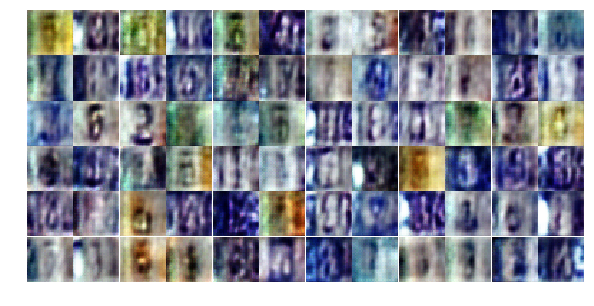

Epoch 3/20... Discriminator Loss: 0.6266... Generator Loss: 1.6381
Epoch 3/20... Discriminator Loss: 0.7217... Generator Loss: 1.6266
Epoch 3/20... Discriminator Loss: 0.8620... Generator Loss: 1.2878
Epoch 3/20... Discriminator Loss: 1.9028... Generator Loss: 0.2342
Epoch 3/20... Discriminator Loss: 0.8503... Generator Loss: 1.1366
Epoch 3/20... Discriminator Loss: 0.9733... Generator Loss: 1.0848
Epoch 3/20... Discriminator Loss: 1.1780... Generator Loss: 0.6724
Epoch 3/20... Discriminator Loss: 1.3849... Generator Loss: 1.0291
Epoch 3/20... Discriminator Loss: 1.0465... Generator Loss: 1.0706
Epoch 3/20... Discriminator Loss: 0.8553... Generator Loss: 1.0921


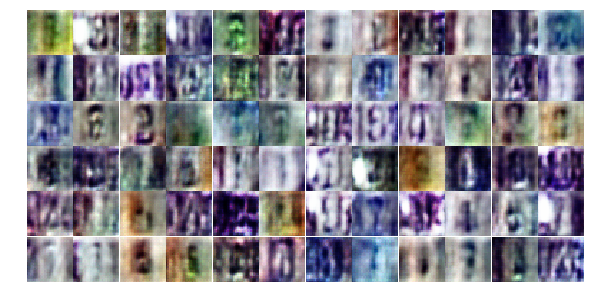

Epoch 3/20... Discriminator Loss: 1.1902... Generator Loss: 0.5349
Epoch 3/20... Discriminator Loss: 0.7036... Generator Loss: 1.2157
Epoch 3/20... Discriminator Loss: 0.8821... Generator Loss: 1.3229
Epoch 3/20... Discriminator Loss: 0.7127... Generator Loss: 1.2785
Epoch 3/20... Discriminator Loss: 0.8490... Generator Loss: 1.1831
Epoch 3/20... Discriminator Loss: 1.7324... Generator Loss: 1.5552
Epoch 3/20... Discriminator Loss: 0.9136... Generator Loss: 0.8761
Epoch 3/20... Discriminator Loss: 0.6910... Generator Loss: 1.3873
Epoch 3/20... Discriminator Loss: 1.7150... Generator Loss: 0.3759
Epoch 3/20... Discriminator Loss: 1.1414... Generator Loss: 0.8017


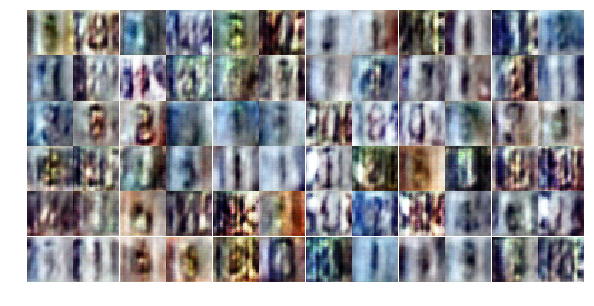

Epoch 3/20... Discriminator Loss: 1.1036... Generator Loss: 1.0395
Epoch 3/20... Discriminator Loss: 0.7495... Generator Loss: 1.8866
Epoch 3/20... Discriminator Loss: 1.3652... Generator Loss: 0.4724
Epoch 3/20... Discriminator Loss: 0.8750... Generator Loss: 1.4290
Epoch 3/20... Discriminator Loss: 1.4722... Generator Loss: 0.7285
Epoch 3/20... Discriminator Loss: 1.0922... Generator Loss: 1.0600
Epoch 3/20... Discriminator Loss: 0.8600... Generator Loss: 1.3880
Epoch 3/20... Discriminator Loss: 0.7650... Generator Loss: 1.1892
Epoch 3/20... Discriminator Loss: 0.8469... Generator Loss: 1.1592
Epoch 3/20... Discriminator Loss: 1.2493... Generator Loss: 0.5343


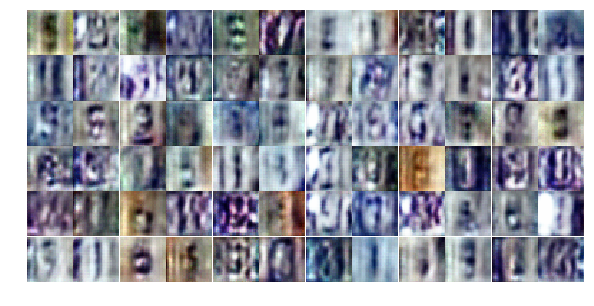

Epoch 3/20... Discriminator Loss: 0.8696... Generator Loss: 1.1419


KeyboardInterrupt: 

In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))